# Neural Image Caption
Original paper: https://arxiv.org/pdf/1411.4555.pdf

Not exactly the same but implementing something similar with more up to date tools

Basic idea: Input Image -> CNN -> Image Embedding -> LSTM -> Image Caption

In [3]:
from transformers import MobileViTImageProcessor, MobileViTForImageClassification, AutoModel, AutoConfig
from sentence_transformers import SentenceTransformer
import torch
from torchvision.transforms import v2
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nltk
import numpy as np
import pandas as pd
from PIL import Image
import requests
import matplotlib.pyplot as plt
%matplotlib inline

# Fixes matplotlib crashing jupyter kernel issue (should find out what this actually does, something to do with OpenMP?)
import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

C:\Users\Stephen\Anaconda3\envs\PyTorchEnv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\Stephen\Anaconda3\envs\PyTorchEnv\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future 

In [4]:
# Read images into array

# Image paths
image_paths = ["cat1.png", "cat2.jpg", "river.jpg"]

# Open the images
images = [Image.open(path).resize((256,256)) for path in image_paths]

# Convert the PIL images to NumPy arrays
image_arrays = [np.array(image) for image in images]

# Combine the arrays into a single array (stack vertically)
combined_array = np.stack(image_arrays, axis=0)    
print(combined_array.shape)

(3, 256, 256, 3)


In [5]:
# Some unrelated notes on hugging face that's good to remember
#
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
#
# MobileViTForImageClassification vs. AutoModel
# For our use case we need to obtain image embeddings so using AutoModel makes more sense as it outputs the dense 
# representations of the images and not the logits, which are what MobileViTForImageClassification would have provided
#
# This would be for actual image classification:
#
# model = MobileViTForImageClassification.from_pretrained("apple/mobilevit-xx-small")
# outputs = model(**inputs, output_hidden_states=True)
# logits = outputs.logits
#
# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])

# Pulling pre-trained image classification model from hugging face
feature_extractor = MobileViTImageProcessor.from_pretrained("apple/mobilevit-xx-small")
model = AutoModel.from_pretrained("apple/mobilevit-xx-small")

# Preprocess batch of images
# Images can be PIL image, numpy array, or torch tensor individually or in list form
inputs = feature_extractor(images=combined_array, return_tensors="pt")
outputs = model(**inputs)
out = outputs.pooler_output # backup plan: last_hidden_state for embeddings instead
print(out.shape)

torch.Size([3, 320])


In [6]:
# Testing embeddings
with torch.no_grad():
    sim1 = torch.nn.functional.cosine_similarity(out[0], out[2], dim=0)
    sim2 = torch.nn.functional.cosine_similarity(out[0], out[1], dim=0)
    print("Cat1 vs. River similarity:", sim1)
    print("Cat1 vs. Cat2 similarity:", sim2)

Cat1 vs. River similarity: tensor(-0.0756)
Cat1 vs. Cat2 similarity: tensor(0.5102)


In [7]:
class ImageEncoderCNN(torch.nn.Module):
    def __init__(self, embed_size):
        super(ImageEncoderCNN, self).__init__()
        # Load pre-trained model
        self.model = AutoModel.from_pretrained("apple/mobilevit-xx-small")
        
        # Freeze layers of pre-trained model
        for param in self.model.parameters():
            param.requires_grad = False
        
        # 320 is the size the pooler_output that I'm using as the last layer of the pre-trained.
        # Passed through this liner layer to get to the same size as the word embeddings so I can pass it to the LSTM.
        # Future: Maybe look into using different layer from pre-trained model as the output
        self.linear = torch.nn.Linear(320, embed_size)
        
    def forward(self, images):
        outputs = self.model(images)
        
        # Pull image embeddings
        embeddings = outputs.pooler_output
        
        # Pass image embeddings through linear layer to reach desired size of LSTM input
        image_embeddings = self.linear(embeddings)
        
        return image_embeddings


In [8]:
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/build_vocab.py
import nltk
import pickle
from collections import Counter

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(dataframe, threshold=4):
    """Build a simple vocabulary wrapper."""
    counter = Counter()

    for caption in dataframe['caption']:
        tokens = nltk.tokenize.word_tokenize(caption)
        counter.update(tokens)

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab


In [9]:
# Create dataset class
class FlickrDataset(Dataset):
    
    def __init__(self, image_dir, dataframe, vocab, image_processor):
        
        self.image_dir = image_dir
        self.dataframe = dataframe
        self.vocab = vocab
        self.image_processor = image_processor
    
    def __getitem__(self, idx):
        
        row = self.dataframe.iloc[idx]
        image_file = row.iloc[0]
        caption = row.iloc[1]
        
        # Convert caption (string) to word ids
        tokens = nltk.tokenize.word_tokenize(caption)
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.tensor(caption, dtype=torch.long)
        
        raw_image = Image.open(os.path.join(self.image_dir, image_file)).convert('RGB')
        processed_image = self.image_processor(images=raw_image, return_tensors="pt")
        image = processed_image.pixel_values.squeeze(0)
        
        return image, target
    
    def viewImage(self, idx):
    
        row = self.dataframe.iloc[idx]
        image_file = row.iloc[0]
        caption = row.iloc[1]
        image = Image.open(os.path.join(self.image_dir, image_file)).convert('RGB')
            
        return image, caption
    
    def __len__(self):
        return len(self.dataframe)
    

In [10]:
def collate_fn(data):
    
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [45]:
%%time
# Generate embeddings for the vocab
sent_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-V2')
embeddings_lst = []

def embedding(texts):
    embs = sent_model.encode(texts)
    return embs

# for i in range(len(vocab)):
#     word = vocab.idx2word[i]
#     embeddings_lst.append(embedding(word))
#     if i % 500 == 0:
#         print(i)
        
# np_arr = np.array(embeddings_lst)
# final_embeddings = torch.Tensor(np_arr)
# print(final_embeddings.shape)

CPU times: total: 562 ms
Wall time: 485 ms


In [11]:
final_embeddings = torch.load("embeddings_table.pt")

In [20]:
class CaptionDecoderRNN(torch.nn.Module):
    def __init__(self, word_embeddings, hidden_size, embedding_size, vocab_size, max_seq_length=25):
        super(CaptionDecoderRNN, self).__init__()
        # Load pre-trained embeddings
        self.embed = torch.nn.Embedding.from_pretrained(word_embeddings, freeze=True) # Future: Try unfreezing?
        self.lstm = torch.nn.LSTM(embedding_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, image_embeddings, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((image_embeddings.unsqueeze(1), embeddings), 1)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])

        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [13]:
def create_dataloader(image_dir, dataframe, vocab, image_processor, batch_size=128):
    flickr = FlickrDataset(image_dir, dataframe, vocab, image_processor)

    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=flickr, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    
    return data_loader

In [16]:
%%time
# FlickrDataset test
torch.manual_seed(9856)
df = pd.read_csv("captions.txt")
df['caption'] = df['caption'].str.lower()
df['caption'] = df['caption'].str.replace(r"[^a-zA-Z0-9-' ]", '', regex=True)

# transform = v2.Compose([ 
#     v2.PILToTensor() 
# ])

# vocab = build_vocab(df, threshold=4)
# vocab_path = "./vocab.pkl"
# with open(vocab_path, 'wb') as f:
#     pickle.dump(vocab, f)
# print("Total vocabulary size: {}".format(len(vocab)))
# print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

# Define embedding model
sent_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-V2')

# Define image processor
ImageProcessor = MobileViTImageProcessor.from_pretrained("apple/mobilevit-xx-small")

with open("./vocab.pkl", 'rb') as f:
    vocab = pickle.load(f)

data_loader = create_dataloader("./Images", df, vocab, ImageProcessor, batch_size=256)

# Define models
encoder = ImageEncoderCNN(embed_size=384)
decoder = CaptionDecoderRNN(final_embeddings, 512, final_embeddings.shape[1], len(vocab))

encoder.train()
decoder.train()

all_params = list(decoder.parameters()) + list(encoder.linear.parameters())
print("Parameters:",sum(p.nelement() for p in all_params))
opt = torch.optim.Adam(all_params, lr=0.0003)

# epochs = 1
# for epoch in range(epochs):
#     for i, (images, captions, lengths) in enumerate(data_loader):
#         targets = torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
#         image_features = encoder(images)
#         logits = decoder(image_features, captions, lengths)
#         loss = torch.nn.functional.cross_entropy(logits, targets)
#         decoder.zero_grad()
#         encoder.zero_grad()
#         loss.backward()
#         opt.step()
        
#         if i % 25 == 0:
#             print(loss.item())
#             torch.save(decoder.state_dict(), './decoder_{}_{}.ckpt'.format(epoch, i))
#             torch.save(encoder.state_dict(), './encoder_{}_{}.ckpt'.format(epoch, i))
#         break
            
# # Save the model
# torch.save(decoder.state_dict(), './decoder_final.ckpt')
# torch.save(encoder.state_dict(), './encoder_final.ckpt')

Parameters: 5043563
CPU times: total: 1.56 s
Wall time: 1.24 s


<start> a group of people are riding a boat in a snowy <end>


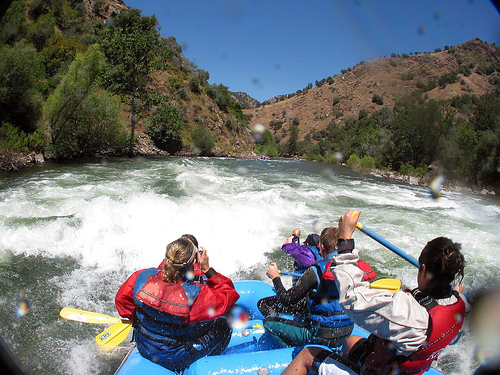

In [50]:
# Build models
torch.manual_seed(12337)

encoder1 = ImageEncoderCNN(384).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder1 = CaptionDecoderRNN(final_embeddings, 512, final_embeddings.shape[1], len(vocab))
#encoder1 = encoder1.to(device)
#decoder1 = decoder1.to(device)


# Load the trained model parameters
encoder1.load_state_dict(torch.load("./cpoints/encoder_final.ckpt", map_location=torch.device('cpu')))
decoder1.load_state_dict(torch.load("./cpoints/decoder_final.ckpt", map_location=torch.device('cpu')))

# encoder1.load_state_dict(torch.load("./cpoints/encoder_9_300.ckpt", map_location=torch.device('cpu')))
# decoder1.load_state_dict(torch.load("./cpoints/decoder_9_300.ckpt", map_location=torch.device('cpu')))

# Sample Image
raw_image = Image.open("./Images/84713990_d3f3cef78b.jpg").convert('RGB')
preprocessed_image = feature_extractor(images=raw_image, return_tensors="pt") # Normalize images at some point?
image_tensor = preprocessed_image.pixel_values

image_embedding = encoder1(image_tensor)
sampled_ids = decoder1.sample(image_embedding)
sampled_ids = sampled_ids[0].numpy()          # (1, max_seq_length) -> (max_seq_length)

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print (sentence)
display(raw_image)